# Method 2: Geodemographics

Now that we have synthetic granular data representing BSA results for the entire adult population of York, we can set about using this data to create clusters to represent voting habits in York.

### Step 1: Importing packages

In [1]:
import pandas as pd
import geopandas as gpd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist, pdist
import numpy as np
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import copy

### Step 2: Importing our CSV file and our shapefile, and merging them
In this step, we take our aggregate dataframe and our shapefile containing electoral wards in York, and we combine them into one geodataframe, which we then export as a shapefile. Doing this means that the following code only needs to be run once, therefore it is now hashtagged out as the merged file is included with the data package to reproduce this paper.

In [2]:
york_shapefile = gpd.read_file('data/York_boundaries/york_electoral_boundaries.shp')
york_BSA = pd.read_csv('data/BSA_agg.csv', low_memory=False)

In [3]:
BSA_geom = york_BSA.merge(york_shapefile, on='geo_code', how='left')
BSA_geom = gpd.GeoDataFrame(BSA_geom, geometry="geometry")

In [4]:
#BSA_geom.to_file('data/geodemographics shapefile/BSA_agg_geom.shp')

Therefore, when you want to run this code, you need only run the line below to import the merged file, saving on processing time.

In [5]:
#BSA_geom = gpd.read_file('data/geodemographics shapefile/BSA_agg_geom.shp')

In [6]:
BSA_geom.columns

Index(['geo_code', 'total_pop', 'age1864', 'age65', 'female', 'male',
       'support_yes', 'support_no', 'support_DNR', 'support_conservative',
       'support_labour', 'support_libdem', 'support_green', 'support_ukip',
       'support_brexit', 'support_other', 'support_none',
       'support_no_response', 'political_interest_yes',
       'political_interest_no', 'welfare_pro', 'welfare_anti',
       'welfare_middle', 'welfare_no_response', 'wealth_redist_pro',
       'wealth_redist_anti', 'wealth_redist_neither', 'lean_left',
       'lean_right', 'lean_centrist', 'lean_no_response', 'libertarian',
       'authoritarian', 'neither_lib_auth', 'rel_christian',
       'rel_nonChristian', 'rel_none', 'rel_other', 'rel_no_response',
       'nat_british', 'nat_english', 'nat_european', 'nat_irish',
       'nat_scottish', 'nat_welsh', 'nat_other_none', 'nat_no_reponse',
       'race_asian', 'race_white', 'race_mixed', 'race_other',
       'race_no_response', 'disab_affect', 'disab_no_affect'

In [7]:
BSA_geom.head()

,geo_code,total_pop,age1864,age65,female,male,support_yes,support_no,support_DNR,support_conservative,...,voted_conservative,voted_labour,voted_libdem,voted_green,voted_UKIP,voted_other,voted_no_reponse,ons_label,geo_label,geometry
0,E05001745,6736,5191,1545,3508,3228,3400,3312,24,2051,...,2361,2609,734,338,111,129,454,00FFNG,Acomb,"POLYGON ((456577.594 451960.781, 456577.934 45..."
1,E05001746,3179,2175,1004,1680,1499,1622,1547,10,1006,...,1148,1192,363,154,48,59,215,00FFNH,Bishopthorpe,"POLYGON ((459746.803 446400.173, 459746.777 44..."
2,E05001747,11113,9413,1700,5821,5292,5538,5530,45,3266,...,3806,4423,1163,572,192,228,729,00FFNJ,Clifton,"POLYGON ((460891.532 453105.406, 460891.778 45..."
3,E05001748,2914,1875,1039,1535,1379,1502,1402,10,954,...,1073,1072,333,132,45,52,207,00FFNK,Derwent,"POLYGON ((466449.953 448892.953, 466428.813 44..."
4,E05001749,8973,6666,2307,4712,4261,4533,4408,32,2766,...,3175,3454,988,433,146,171,606,00FFNL,Dringhouses and Woodthorpe,"POLYGON ((458809.029 450627.601, 458823.125 45..."


### Step 3: Selecting our variables

Creating histograms to justify variable selection

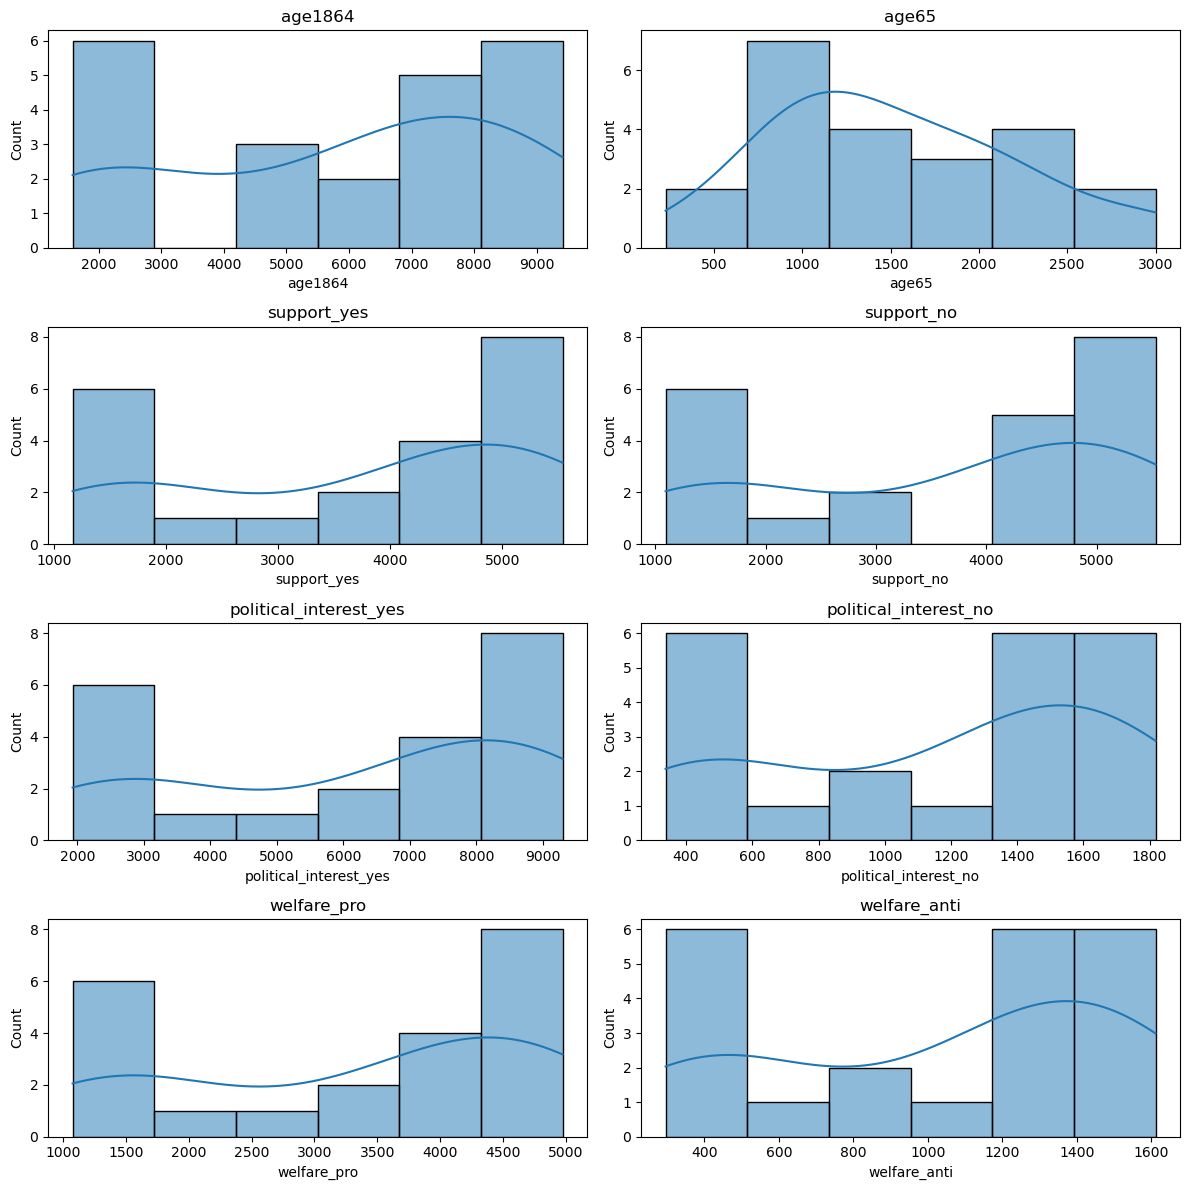

In [9]:
attributes_to_plot = ['age1864',
                      'age65',
                      'support_yes',
                      'support_no',
                      'political_interest_yes',
                      'political_interest_no',
                      'welfare_pro', 
                      'welfare_anti'
                     ]

plt.figure(figsize=(12, 12))

for i, attribute in enumerate(attributes_to_plot,1):
    plt.subplot(4, 2, i)
    sns.histplot(BSA_geom[attribute], kde=True)
    plt.title(attribute)

plt.tight_layout()
plt.savefig("/Users/saffytaylor/Desktop/histograms1.png") # saving the output as it's too large to screenshot
plt.show()

In [ ]:
attributes_to_plot = ['voted_conservative',
                      'voted_labour',
                      'voted_libdem',
                      'voted_green',
                      'voted_UKIP',
                      'voted_other',
                     ]

plt.figure(figsize=(12, 12))

for i, attribute in enumerate(attributes_to_plot,1):
    plt.subplot(4, 2, i)
    sns.histplot(BSA_geom[attribute], kde=True)
    plt.title(attribute)

plt.tight_layout()
plt.show()

### Step 4: Subsetting the data

In this step we create a new dataframe of only the variables we need, and transform the aggregate counts into percentages of the total population. As we know from our <a href="cleaning.ipynb#Step-4:-Validation-and-checking-the-data-to-ensure-we've-aggregated-it-correctly">cleaning</a> that within each category of data (age, sex, race, who they voted for), the entire population of York is represented across the columns representing that category. Therefore we calculate all percentages using the 'total_pop' column, and subset the results into a new dataframe just containing the relevant percentages.

After this, we rename the columns to make referring to particular columns easier later on.

In [10]:
def percentages(dataframe, value_columns): # function to calculate percentages

    result_df = pd.DataFrame() # initialises a new results dataframe

    for i in value_columns: # for loop to calculate percentages
        percentage_col_name = f"{i}_percentage"
        result_df[percentage_col_name] = (dataframe[i] / dataframe['total_pop']) * 100
        
    return result_df # returns the new dataframe

# List of the columns we're going to standardise
value_cols = ['age1864', 'age65',
              'female', 'male',
              'support_yes', 'support_no',
              'political_interest_yes', 'political_interest_no',
              'welfare_pro', 'welfare_anti',
              'wealth_redist_pro', 'wealth_redist_anti',
              'lean_left','lean_right', 'lean_centrist',
              'rel_christian', 'rel_nonChristian', 'rel_none', 'rel_other',
              'nat_british', 'nat_english', 'nat_european', 'nat_irish',
              'nat_scottish', 'nat_welsh', 'nat_other_none',
              'race_white', 'race_asian', 'race_mixed', 'race_other',
              'disab_affect', 'disab_no_affect', 'disab_none',
             ]


percentage_results = percentages(BSA_geom, value_cols)

In [11]:
percentage_results.shape

(22, 33)

In [12]:
# join it to the merged dataframe!
BSA_geom_perc = pd.concat([BSA_geom, percentage_results], axis=1, ignore_index=False)
BSA_geom_perc.head()

,geo_code,total_pop,age1864,age65,female,male,support_yes,support_no,support_DNR,support_conservative,...,nat_scottish_percentage,nat_welsh_percentage,nat_other_none_percentage,race_white_percentage,race_asian_percentage,race_mixed_percentage,race_other_percentage,disab_affect_percentage,disab_no_affect_percentage,disab_none_percentage
0,E05001745,6736,5191,1545,3508,3228,3400,3312,24,2051,...,0.237530,0.237530,4.156770,92.309976,1.929929,1.855701,2.850356,10.629454,14.533848,74.465558
1,E05001746,3179,2175,1004,1680,1499,1622,1547,10,1006,...,0.346021,0.377477,4.089336,92.607738,1.793017,1.793017,2.673797,11.041208,16.042781,72.507078
2,E05001747,11113,9413,1700,5821,5292,5538,5530,45,3266,...,0.161972,0.161972,4.247278,91.955368,2.078647,1.943670,3.032484,10.438226,13.353730,75.812112
3,E05001748,2914,1875,1039,1535,1379,1502,1402,10,954,...,0.446122,0.411805,3.980782,92.896362,1.612903,1.715854,2.642416,11.084420,16.231984,72.374743
4,E05001749,8973,6666,2307,4712,4261,4533,4408,32,2766,...,0.278614,0.278614,4.123482,92.455143,1.849994,1.861139,2.786136,10.743341,14.933690,73.966343


In [13]:
BSA_geom_perc.columns

Index(['geo_code', 'total_pop', 'age1864', 'age65', 'female', 'male',
       'support_yes', 'support_no', 'support_DNR', 'support_conservative',
       'support_labour', 'support_libdem', 'support_green', 'support_ukip',
       'support_brexit', 'support_other', 'support_none',
       'support_no_response', 'political_interest_yes',
       'political_interest_no', 'welfare_pro', 'welfare_anti',
       'welfare_middle', 'welfare_no_response', 'wealth_redist_pro',
       'wealth_redist_anti', 'wealth_redist_neither', 'lean_left',
       'lean_right', 'lean_centrist', 'lean_no_response', 'libertarian',
       'authoritarian', 'neither_lib_auth', 'rel_christian',
       'rel_nonChristian', 'rel_none', 'rel_other', 'rel_no_response',
       'nat_british', 'nat_english', 'nat_european', 'nat_irish',
       'nat_scottish', 'nat_welsh', 'nat_other_none', 'nat_no_reponse',
       'race_asian', 'race_white', 'race_mixed', 'race_other',
       'race_no_response', 'disab_affect', 'disab_no_affect'

In [14]:
keep = ['geo_code',
        'geometry',
        'age1864_percentage',
        'age65_percentage',
        'female_percentage',
        'male_percentage',
        'political_interest_yes_percentage',
        'political_interest_no_percentage',
        'welfare_pro_percentage',
        'welfare_anti_percentage',
        'wealth_redist_pro_percentage',
        'wealth_redist_anti_percentage',
        'lean_left_percentage',
        'lean_right_percentage', 
        'lean_centrist_percentage',
        'rel_christian_percentage',
        'rel_nonChristian_percentage',
        'rel_none_percentage',
        'rel_other_percentage', 
        'nat_british_percentage', 
        'nat_english_percentage', 
        'nat_european_percentage', 
        'nat_irish_percentage',
        'nat_scottish_percentage', 
        'nat_welsh_percentage', 
        'nat_other_none_percentage',
        'race_white_percentage',
        'race_asian_percentage', 
        'race_mixed_percentage',
        'race_other_percentage', 
        'disab_affect_percentage',
        'disab_no_affect_percentage', 
        'disab_none_percentage',

       ]

bsa_perc_sub = BSA_geom_perc[keep]

In [15]:
bsa_perc_sub.head()

,geo_code,geometry,age1864_percentage,age65_percentage,female_percentage,male_percentage,political_interest_yes_percentage,political_interest_no_percentage,welfare_pro_percentage,welfare_anti_percentage,...,nat_scottish_percentage,nat_welsh_percentage,nat_other_none_percentage,race_white_percentage,race_asian_percentage,race_mixed_percentage,race_other_percentage,disab_affect_percentage,disab_no_affect_percentage,disab_none_percentage
0,E05001745,"POLYGON ((456577.594 451960.781, 456577.934 45...",77.063539,22.936461,52.078385,47.921615,84.412114,15.587886,45.665083,14.088480,...,0.237530,0.237530,4.156770,92.309976,1.929929,1.855701,2.850356,10.629454,14.533848,74.465558
1,E05001746,"POLYGON ((459746.803 446400.173, 459746.777 44...",68.417741,31.582259,52.846807,47.153193,85.121107,14.878893,46.492608,13.400440,...,0.346021,0.377477,4.089336,92.607738,1.793017,1.793017,2.673797,11.041208,16.042781,72.507078
2,E05001747,"POLYGON ((460891.532 453105.406, 460891.778 45...",84.702601,15.297399,52.380095,47.619905,83.640781,16.359219,44.776388,14.496536,...,0.161972,0.161972,4.247278,91.955368,2.078647,1.943670,3.032484,10.438226,13.353730,75.812112
3,E05001748,"POLYGON ((466449.953 448892.953, 466428.813 44...",64.344544,35.655456,52.676733,47.323267,85.655456,14.344544,46.602608,13.383665,...,0.446122,0.411805,3.980782,92.896362,1.612903,1.715854,2.642416,11.084420,16.231984,72.374743
4,E05001749,"POLYGON ((458809.029 450627.601, 458823.125 45...",74.289535,25.710465,52.513095,47.486905,84.531372,15.468628,45.804079,13.908392,...,0.278614,0.278614,4.123482,92.455143,1.849994,1.861139,2.786136,10.743341,14.933690,73.966343


Renaming our subset of percentage columns for easy analysis, a lot of these names are quite long so we'll give them shorter names to make them easier to work with.

In [16]:
rename_columns = { 
        'age1864_percentage': 'adults18_64',
        'age65_percentage': 'adults65pl',
        'female_percentage': 'female',
        'male_percentage': 'male',
        'political_interest_yes_percentage': 'polInter_yes',
        'political_interest_no_percentage': 'polInter_no',
        'welfare_pro_percentage': 'welf_pro',
        'welfare_anti_percentage': 'welf_anti',
        'wealth_redist_pro_percentage': 'redist_pro',
        'wealth_redist_anti_percentage': 'redist_anti',
        'lean_left_percentage': 'lean_left',
        'lean_right_percentage': 'lean_right',
        'lean_centrist_percentage': 'lean_centr',
        'rel_christian_percentage': 'rel_christ',
        'rel_nonChristian_percentage': 'rel_nonchrist',
        'rel_none_percentage': 'rel_non',
        'rel_other_percentage': 'rel_other',
        'nat_british_percentage': 'nat_british',
        'nat_english_percentage': 'nat_english',
        'nat_european_percentage': 'nat_euro',
        'nat_irish_percentage': 'nat_irish',
        'nat_scottish_percentage': 'nat_scottish',
        'nat_welsh_percentage': 'nat_welsh',
        'nat_other_none_percentage': 'nat_other',
        'race_white_percentage': 'race_white',
        'race_asian_percentage': 'race_asian',
        'race_mixed_percentage': 'race_mixed',
        'race_other_percentage': 'race_other',
        'disab_affect_percentage': 'disab_aff',
        'disab_no_affect_percentage': 'disab_noAff',
        'disab_none_percentage': 'disab_None',

                 }

bsa_perc_sub = bsa_perc_sub.rename(columns=rename_columns)

In [17]:
bsa_perc_sub.head()

,geo_code,geometry,adults18_64,adults65pl,female,male,polInter_yes,polInter_no,welf_pro,welf_anti,...,nat_scottish,nat_welsh,nat_other,race_white,race_asian,race_mixed,race_other,disab_aff,disab_noAff,disab_None
0,E05001745,"POLYGON ((456577.594 451960.781, 456577.934 45...",77.063539,22.936461,52.078385,47.921615,84.412114,15.587886,45.665083,14.088480,...,0.237530,0.237530,4.156770,92.309976,1.929929,1.855701,2.850356,10.629454,14.533848,74.465558
1,E05001746,"POLYGON ((459746.803 446400.173, 459746.777 44...",68.417741,31.582259,52.846807,47.153193,85.121107,14.878893,46.492608,13.400440,...,0.346021,0.377477,4.089336,92.607738,1.793017,1.793017,2.673797,11.041208,16.042781,72.507078
2,E05001747,"POLYGON ((460891.532 453105.406, 460891.778 45...",84.702601,15.297399,52.380095,47.619905,83.640781,16.359219,44.776388,14.496536,...,0.161972,0.161972,4.247278,91.955368,2.078647,1.943670,3.032484,10.438226,13.353730,75.812112
3,E05001748,"POLYGON ((466449.953 448892.953, 466428.813 44...",64.344544,35.655456,52.676733,47.323267,85.655456,14.344544,46.602608,13.383665,...,0.446122,0.411805,3.980782,92.896362,1.612903,1.715854,2.642416,11.084420,16.231984,72.374743
4,E05001749,"POLYGON ((458809.029 450627.601, 458823.125 45...",74.289535,25.710465,52.513095,47.486905,84.531372,15.468628,45.804079,13.908392,...,0.278614,0.278614,4.123482,92.455143,1.849994,1.861139,2.786136,10.743341,14.933690,73.966343


In [18]:
bsa_perc_sub.columns

Index(['geo_code', 'geometry', 'adults18_64', 'adults65pl', 'female', 'male',
       'polInter_yes', 'polInter_no', 'welf_pro', 'welf_anti', 'redist_pro',
       'redist_anti', 'lean_left', 'lean_right', 'lean_centr', 'rel_christ',
       'rel_nonchrist', 'rel_non', 'rel_other', 'nat_british', 'nat_english',
       'nat_euro', 'nat_irish', 'nat_scottish', 'nat_welsh', 'nat_other',
       'race_white', 'race_asian', 'race_mixed', 'race_other', 'disab_aff',
       'disab_noAff', 'disab_None'],
      dtype='object')

### Step 5: Z-scores and measuring for association
To finish standardising variables, we next calculate z-scores for each column, saving these into a new dataframe ('bsa_z'). Then we use these to measure for association.

In [19]:
numeric_columns = bsa_perc_sub.select_dtypes(include='float64') # subsetting for just the numeric columns
bsa_z = (numeric_columns - numeric_columns.mean()) / numeric_columns.std(ddof=0)
bsa_z.head()

,adults18_64,adults65pl,female,male,polInter_yes,polInter_no,welf_pro,welf_anti,redist_pro,redist_anti,...,nat_scottish,nat_welsh,nat_other,race_white,race_asian,race_mixed,race_other,disab_aff,disab_noAff,disab_None
0,-0.071154,0.071154,-0.019627,0.019627,0.149422,-0.149422,0.152599,0.001629,0.156719,-0.104786,...,-0.019160,-0.053943,0.176463,0.127210,-0.016251,-0.571422,-0.102868,0.067284,0.042557,-0.053544
1,-1.122921,1.122921,0.512448,-0.512448,1.055018,-1.055018,1.044380,-1.265612,-0.111585,-1.132945,...,1.067955,1.406714,-0.579996,0.829422,-0.818764,-1.283546,-0.855798,1.305876,1.243604,-1.329029
2,0.858143,-0.858143,0.189285,-0.189285,-0.835800,0.835800,-0.805103,0.753191,0.055573,0.887430,...,-0.776267,-0.842547,1.191775,-0.709063,0.855462,0.427951,0.673809,-0.507947,-0.896767,0.823416
3,-1.618428,1.618428,0.394684,-0.394684,1.737541,-1.737541,1.162922,-1.296509,-2.922301,-0.672972,...,2.071003,1.765000,-1.797739,1.510084,-1.874502,-2.160149,-0.989621,1.435862,1.394201,-1.415214
4,-0.408613,0.408613,0.281377,-0.281377,0.301750,-0.301750,0.302388,-0.330060,-0.435911,-0.147296,...,0.392514,0.374858,-0.196958,0.469557,-0.484787,-0.509641,-0.376732,0.409867,0.360815,-0.378664


In [20]:
corr_colourmap = bsa_z.corr()
corr_colourmap.style.background_gradient(cmap='coolwarm')

,adults18_64,adults65pl,female,male,polInter_yes,polInter_no,welf_pro,welf_anti,redist_pro,redist_anti,lean_left,lean_right,lean_centr,rel_christ,rel_nonchrist,rel_non,rel_other,nat_british,nat_english,nat_euro,nat_irish,nat_scottish,nat_welsh,nat_other,race_white,race_asian,race_mixed,race_other,disab_aff,disab_noAff,disab_None
adults18_64,1.000000,-1.000000,-0.444216,0.444216,-0.993568,0.993568,-0.966089,0.961809,0.445018,0.861467,0.968491,-0.983478,-0.700029,-0.996182,0.860214,0.995433,0.897738,0.903174,-0.818784,0.935428,-0.991167,-0.987585,-0.985374,0.881546,-0.988884,0.979155,0.866609,0.957461,-0.909282,-0.995687,0.994057
adults65pl,-1.000000,1.000000,0.444216,-0.444216,0.993568,-0.993568,0.966089,-0.961809,-0.445018,-0.861467,-0.968491,0.983478,0.700029,0.996182,-0.860214,-0.995433,-0.897738,-0.903174,0.818784,-0.935428,0.991167,0.987585,0.985374,-0.881546,0.988884,-0.979155,-0.866609,-0.957461,0.909282,0.995687,-0.994057
female,-0.444216,0.444216,1.000000,-1.000000,0.365057,-0.365057,0.468138,-0.570120,-0.524774,-0.066015,-0.350296,0.541774,-0.058280,0.514565,-0.104347,-0.522708,-0.273093,-0.076594,-0.042690,-0.648119,0.433872,0.470084,0.542833,-0.549942,0.493315,-0.306227,-0.423436,-0.627919,0.757439,0.422816,-0.508374
male,0.444216,-0.444216,-1.000000,1.000000,-0.365057,0.365057,-0.468138,0.570120,0.524774,0.066015,0.350296,-0.541774,0.058280,-0.514565,0.104347,0.522708,0.273093,0.076594,0.042690,0.648119,-0.433872,-0.470084,-0.542833,0.549942,-0.493315,0.306227,0.423436,0.627919,-0.757439,-0.422816,0.508374
polInter_yes,-0.993568,0.993568,0.365057,-0.365057,1.000000,-1.000000,0.964479,-0.947488,-0.397371,-0.884125,-0.963359,0.964287,0.717347,0.983066,-0.889409,-0.981206,-0.910253,-0.925264,0.850921,-0.912978,0.989575,0.976153,0.969649,-0.868879,0.974032,-0.982708,-0.844765,-0.933300,0.868271,0.992758,-0.981952
polInter_no,0.993568,-0.993568,-0.365057,0.365057,-1.000000,1.000000,-0.964479,0.947488,0.397371,0.884125,0.963359,-0.964287,-0.717347,-0.983066,0.889409,0.981206,0.910253,0.925264,-0.850921,0.912978,-0.989575,-0.976153,-0.969649,0.868879,-0.974032,0.982708,0.844765,0.933300,-0.868271,-0.992758,0.981952
welf_pro,-0.966089,0.966089,0.468138,-0.468138,0.964479,-0.964479,1.000000,-0.984905,-0.271775,-0.799706,-0.888517,0.955890,0.551575,0.963224,-0.842645,-0.961304,-0.915113,-0.839994,0.758527,-0.930915,0.971348,0.932477,0.954916,-0.869077,0.943175,-0.914073,-0.734101,-0.959882,0.892884,0.979242,-0.976658
welf_anti,0.961809,-0.961809,-0.570120,0.570120,-0.947488,0.947488,-0.984905,1.000000,0.356395,0.753162,0.890525,-0.965298,-0.537560,-0.969141,0.789695,0.968766,0.872428,0.800683,-0.698554,0.938127,-0.964840,-0.940374,-0.968403,0.895559,-0.943448,0.896066,0.771875,0.968923,-0.940196,-0.969547,0.980716
redist_pro,0.445018,-0.445018,-0.524774,0.524774,-0.397371,0.397371,-0.271775,0.356395,1.000000,0.197399,0.507460,-0.466040,-0.435580,-0.484620,0.232538,0.490777,0.230108,0.339599,-0.305327,0.513151,-0.409812,-0.540543,-0.483062,0.462211,-0.488822,0.460082,0.729806,0.402146,-0.583729,-0.367519,0.424354
redist_anti,0.861467,-0.861467,-0.066015,0.066015,-0.884125,0.884125,-0.799706,0.753162,0.197399,1.000000,0.886568,-0.794475,-0.831964,-0.825363,0.770289,0.824859,0.769342,0.852774,-0.773775,0.676534,-0.827300,-0.815167,-0.791543,0.691063,-0.836707,0.888595,0.747226,0.757181,-0.625017,-0.870779,0.831249


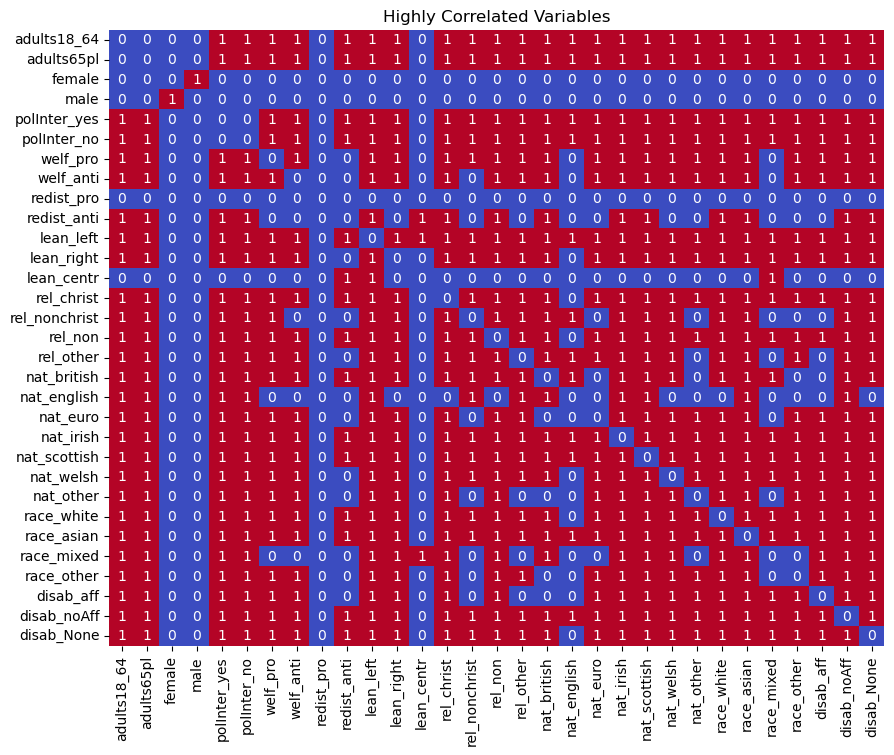

In [21]:
threshold = 0.8

highly_correlated = (corr_colourmap.abs() > threshold) & (corr_colourmap.abs() < 1.0)

plt.figure(figsize=(10, 8))
sns.heatmap(highly_correlated, cmap='coolwarm', cbar=False, annot=True)

plt.title('Highly Correlated Variables')
plt.savefig("data/images/matrix1.png") # saving the output as it's too large to screenshot
plt.show()


As we can see from this graph, there are a lot of highly correlated variables. As discussed within the methods of the report, this can be expected with synthetic data, therefore we will just select the variables we want to include in our clustering regardless of correlations.

In [22]:
bsa_z.drop(['disab_None', 
            'disab_noAff', 
            #'race_other',
            'nat_euro', 
            'nat_irish', 
            'nat_scottish',
            'nat_welsh',
            'nat_other',
            'polInter_no',
            'welf_anti',
            'redist_anti',
            #'lean_right',
            'disab_noAff',
            'rel_other',

            'adults18_64',
            'adults65pl',
            'female',
            'male',

            
           ], axis=1, inplace=True)


In [23]:
corr_colourmap2 = bsa_z.corr()
corr_colourmap2.style.background_gradient(cmap='coolwarm')

,polInter_yes,welf_pro,redist_pro,lean_left,lean_right,lean_centr,rel_christ,rel_nonchrist,rel_non,nat_british,nat_english,race_white,race_asian,race_mixed,race_other,disab_aff
polInter_yes,1.000000,0.964479,-0.397371,-0.963359,0.964287,0.717347,0.983066,-0.889409,-0.981206,-0.925264,0.850921,0.974032,-0.982708,-0.844765,-0.933300,0.868271
welf_pro,0.964479,1.000000,-0.271775,-0.888517,0.955890,0.551575,0.963224,-0.842645,-0.961304,-0.839994,0.758527,0.943175,-0.914073,-0.734101,-0.959882,0.892884
redist_pro,-0.397371,-0.271775,1.000000,0.507460,-0.466040,-0.435580,-0.484620,0.232538,0.490777,0.339599,-0.305327,-0.488822,0.460082,0.729806,0.402146,-0.583729
lean_left,-0.963359,-0.888517,0.507460,1.000000,-0.944257,-0.839363,-0.957995,0.840839,0.957608,0.914426,-0.812708,-0.958545,0.972874,0.922767,0.888643,-0.849739
lean_right,0.964287,0.955890,-0.466040,-0.944257,1.000000,0.615117,0.990503,-0.823401,-0.990282,-0.847835,0.751188,0.989766,-0.952903,-0.855119,-0.977446,0.937440
lean_centr,0.717347,0.551575,-0.435580,-0.839363,0.615117,1.000000,0.662197,-0.652655,-0.661985,-0.792440,0.707491,0.670507,-0.762353,-0.804731,-0.522442,0.486892
rel_christ,0.983066,0.963224,-0.484620,-0.957995,0.990503,0.662197,1.000000,-0.837533,-0.999848,-0.872002,0.782859,0.991710,-0.966951,-0.868783,-0.971753,0.935706
rel_nonchrist,-0.889409,-0.842645,0.232538,0.840839,-0.823401,-0.652655,-0.837533,1.000000,0.828499,0.934529,-0.901495,-0.847621,0.899053,0.695895,0.781833,-0.652362
rel_non,-0.981206,-0.961304,0.490777,0.957608,-0.990282,-0.661985,-0.999848,0.828499,1.000000,0.866605,-0.776093,-0.991302,0.964709,0.871324,0.972071,-0.938928
nat_british,-0.925264,-0.839994,0.339599,0.914426,-0.847835,-0.792440,-0.872002,0.934529,0.866605,1.000000,-0.969214,-0.874329,0.944549,0.808395,0.768983,-0.690423


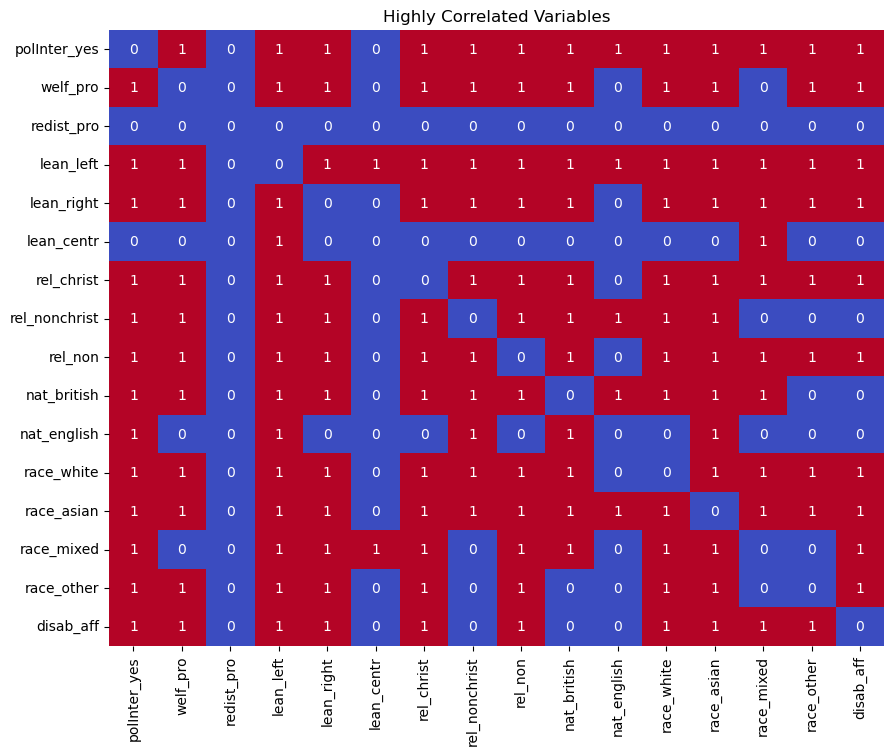

In [24]:
highly_correlated2 = (corr_colourmap2.abs() > threshold) & (corr_colourmap2.abs() < 1.0)

plt.figure(figsize=(10, 8))
sns.heatmap(highly_correlated2, cmap='coolwarm', cbar=False, annot=True)

plt.title('Highly Correlated Variables')
plt.savefig("data/images/matrix2.png") # saving the output as it's too large to screenshot
plt.show()

In [25]:
bsa_z.columns

Index(['polInter_yes', 'welf_pro', 'redist_pro', 'lean_left', 'lean_right',
       'lean_centr', 'rel_christ', 'rel_nonchrist', 'rel_non', 'nat_british',
       'nat_english', 'race_white', 'race_asian', 'race_mixed', 'race_other',
       'disab_aff'],
      dtype='object')

## Step 6: k-Means clustering
The first step to calculating our clusters is to to calculate first how many clusters would fit our data. We can do this with the elbow method, as is shown below:

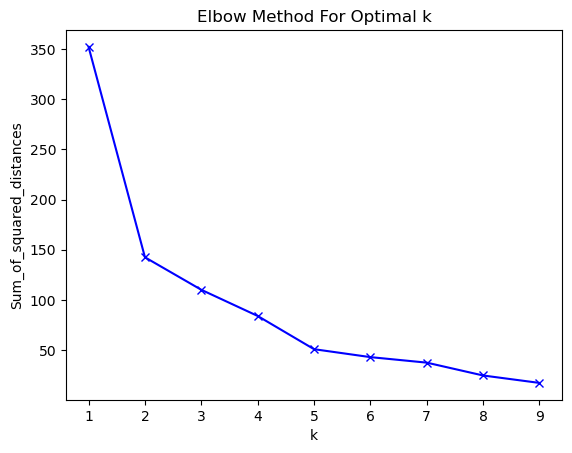

In [39]:
Sum_of_squared_distances = [] 

K_range = range(1,10) # creating a range of potential clusters

for k in K_range:
 km = KMeans(n_clusters=k, random_state=0)
 km = km.fit(bsa_z)
 Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K_range, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

The elbow method shows that the number of clusters that would best fit our data is 2 clusters, maybe up to 5, as this is where the 'elbow' of the line graph is. We also caluclate the between-custer sum of squares to compare results.

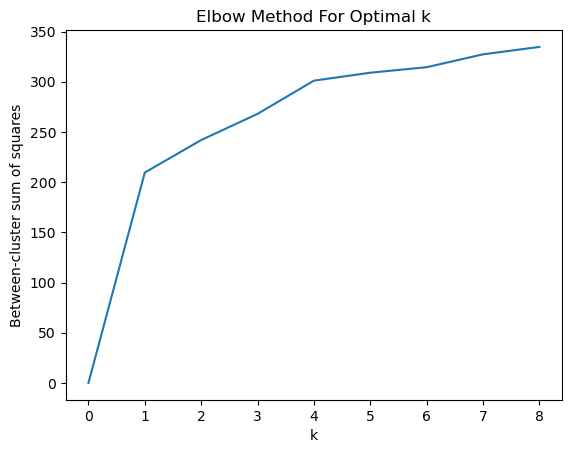

In [40]:
def elbow(dataframe, n): # defining a function for the elbow method
    kMeansVar = [KMeans(n_clusters=k, random_state=0).fit(dataframe.values) for k in range(1, n)]
    centroids = [X.cluster_centers_ for X in kMeansVar]
    k_euclid = [cdist(dataframe.values, cent) for cent in centroids]
    dist = [np.min(ke, axis=1) for ke in k_euclid]
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(dataframe.values)**2)/dataframe.values.shape[0]
    bss = tss - wcss
    plt.plot(bss)
    plt.xlabel('k')
    plt.ylabel('Between-cluster sum of squares')
    plt.title('Elbow Method For Optimal k')
    plt.show()
 
elbow(bsa_z,10)

Comparing the sum of squared distances to the results of the between-cluster sum of squares, the between-cluster sum appears to suggest that around 4 clusters is the peak number. In our first attempt we will go forward with 3 clusters as a first test, and adjust for more tests.

In [41]:
# making a deep copy of the bsa_z dataframe to use to test the use of three clusters
bsa_z3 = bsa_z.copy() # making a deep copy

In [42]:
kmeans3 = KMeans(n_clusters=3, random_state=0) # defining our cluster number as 3 and defining a seed
kmeans3.fit(bsa_z3)
labels = kmeans3.predict(bsa_z3)
cluster_centres3 = kmeans3.cluster_centers_

bsa_z3['Cluster'] = kmeans3.labels_

In [43]:
bsa_z3.to_csv("data/bsa_z3k.csv", index=False) # saving this dataset with 3 clusters

Next we need to evaluate our cluster groups using PCA

In [44]:
clusters3 = kmeans3.fit_predict(bsa_z3)

bsa_z3['Cluster'] = clusters3

scaler3 = StandardScaler()
stand_data_scaled3 = scaler3.fit_transform(bsa_z3)

# PCA analysis
pca3 = PCA(n_components=2).fit(stand_data_scaled3)
pca_result3 = pca3.transform(stand_data_scaled3)

# calculating percentage variance
variance_ratio3 = pca3.explained_variance_ratio_

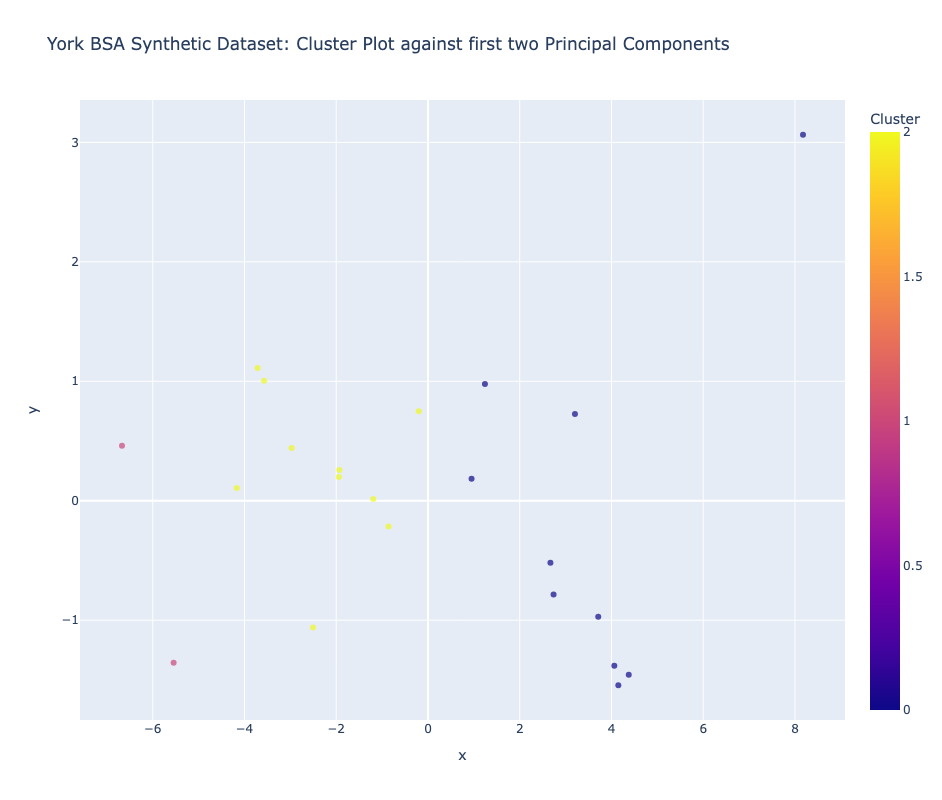

These two components explain 88.32% of the point variability.


<Figure size 1200x800 with 0 Axes>

In [58]:
# printing a scatter plot for results
plt.figure(figsize=(12, 8))
fig = px.scatter(x=pca_result3[:, 0], y=pca_result3[:, 1], color=clusters3,
                 labels={'color': 'Cluster'},
                 title='York BSA Synthetic Dataset: Cluster Plot against first two Principal Components',
                 opacity=0.7,
                 width=800, 
                 height=800)

plt.tight_layout()
fig.show()

print(f"These two components explain {(variance_ratio3.sum()*100):.2f}% of the point variability.")


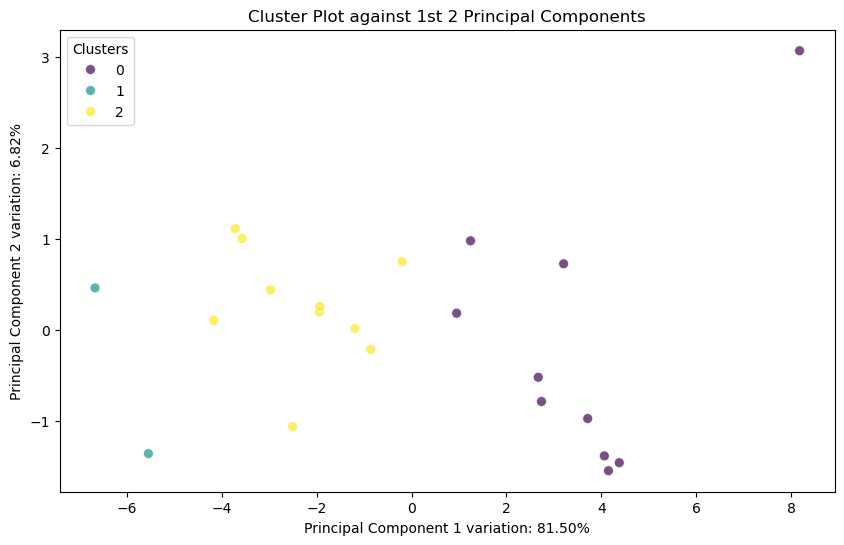

In [59]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_result3[:, 0], y=pca_result3[:, 1], hue=clusters3, palette='viridis', s=50, alpha=0.7)
plt.title('Cluster Plot against 1st 2 Principal Components')
plt.xlabel(f'Principal Component 1 variation: {variance_ratio3[0]*100:.2f}%')
plt.ylabel(f'Principal Component 2 variation: {variance_ratio3[1]*100:.2f}%')
plt.legend(title='Clusters')
plt.show()

Interpreting our cluster centres - creating a dataframe with the coordinates of cluster centres

In [47]:
cluster_centers_k3 = pd.DataFrame(kmeans3.cluster_centers_, columns=bsa_z3.columns, )
cluster_centers_k3.to_csv("data/cluster_centers_k3.csv", index=False)
cluster_centers_k3.head()

,polInter_yes,welf_pro,redist_pro,lean_left,lean_right,lean_centr,rel_christ,rel_nonchrist,rel_non,nat_british,nat_english,race_white,race_asian,race_mixed,race_other,disab_aff,Cluster
0,-0.921017,-0.921241,0.432351,0.926699,-0.934043,-0.687221,-0.940964,0.766390,0.941953,0.772412,-0.634024,-0.935967,0.888659,0.859652,0.931636,-0.888232,0.0
1,1.718994,1.345126,-1.327317,-1.642870,1.504593,1.407678,1.608208,-1.743235,-1.594749,-1.738647,1.920212,1.641068,-1.857669,-1.425107,-1.377841,1.173044,1.0
2,0.577218,0.652216,-0.166888,-0.598125,0.633124,0.405685,0.619323,-0.417743,-0.623003,-0.424682,0.249982,0.607753,-0.517125,-0.574631,-0.656068,0.653623,2.0


### Step 7: Looking at the characteristics of our clusters

The following test is for 3 clusters, however we will also test out different numbers of clusters to see if we can find a better fit. 

In [ ]:
first_row_centers_k3 = cluster_centers_k3.iloc[0, :]

# saving the length of features
num_features_k3 = len(first_row_centers_k3)

# getting the polar coordinates
theta_k3 = np.linspace(0, 2 * np.pi, num_features_k3, endpoint=True)

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
 # plots the centres
ax.plot(theta_k3, first_row_centers_k3, linewidth=1, color='blue', marker='o', label='Centers')

 # adding the red line into the plot where the value is 0.0
ax.plot(theta_k3, np.zeros_like(first_row_centers_k3), color='red', linestyle='--', label='Avarage')

ax.set_xticks(theta_k3)
ax.set_xticklabels(cluster_centers_k3.columns, rotation=45, ha='right')
plt.title("Characteristics of Cluster 1")
plt.show()

In [ ]:
second_row_centers_k3 = cluster_centers_k3.iloc[1, :]

# saving the length of features
num_features_k3 = len(second_row_centers_k3)

# getting the polar coordinates
theta_k3 = np.linspace(0, 2 * np.pi, num_features_k3, endpoint=True)

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
 # plots the centres
ax.plot(theta_k3, second_row_centers_k3, linewidth=1, color='blue', marker='o', label='Centers')

 # adding the red line into the plot where the value is 0.0
ax.plot(theta_k3, np.zeros_like(second_row_centers_k3), color='red', linestyle='--', label='Avarage')

ax.set_xticks(theta_k3)
ax.set_xticklabels(cluster_centers_k3.columns, rotation=45, ha='right')
plt.title("Characteristics of Cluster 2")
plt.show()

In [ ]:
third_row_centers_k3 = cluster_centers_k3.iloc[2, :]

# saving the length of features
num_features_k3 = len(third_row_centers_k3)

# getting the polar coordinates
theta_k3 = np.linspace(0, 2 * np.pi, num_features_k3, endpoint=True)

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
 # plots the centres
ax.plot(theta_k3, third_row_centers_k3, linewidth=1, color='blue', marker='o', label='Centers')

 # adding the red line into the plot where the value is 0.0
ax.plot(theta_k3, np.zeros_like(third_row_centers_k3), color='red', linestyle='--', label='Avarage')

ax.set_xticks(theta_k3)
ax.set_xticklabels(cluster_centers_k3.columns, rotation=45, ha='right')
plt.title("Characteristics of Cluster 3")
plt.show()

## Step 7: Testing different numbers of clusters.

### Test 1: Two Clusters

In [48]:
bsa_z2 = bsa_z.copy() # making a deep copy

In [49]:
kmeans2 = KMeans(n_clusters=2, random_state=0) # defining our cluster number as 2 and defining a seed
kmeans2.fit(bsa_z2)
labels = kmeans2.predict(bsa_z2)
cluster_centres2 = kmeans2.cluster_centers_

bsa_z2['Cluster'] = kmeans2.labels_

In [50]:
bsa_z2.to_csv("data/bsa_z2k.csv", index=False) # saving this dataset with 2 clusters

In [51]:
clusters2 = kmeans2.fit_predict(bsa_z2)

bsa_z2['Cluster'] = clusters2

# Standardize the data for PCA
scaler2 = StandardScaler()
stand_data_scaled2 = scaler2.fit_transform(bsa_z2)

pca2 = PCA(n_components=2).fit(stand_data_scaled2)
pca_result2 = pca2.transform(stand_data_scaled2)

# calculating percentage variance
variance_ratio2 = pca2.explained_variance_ratio_

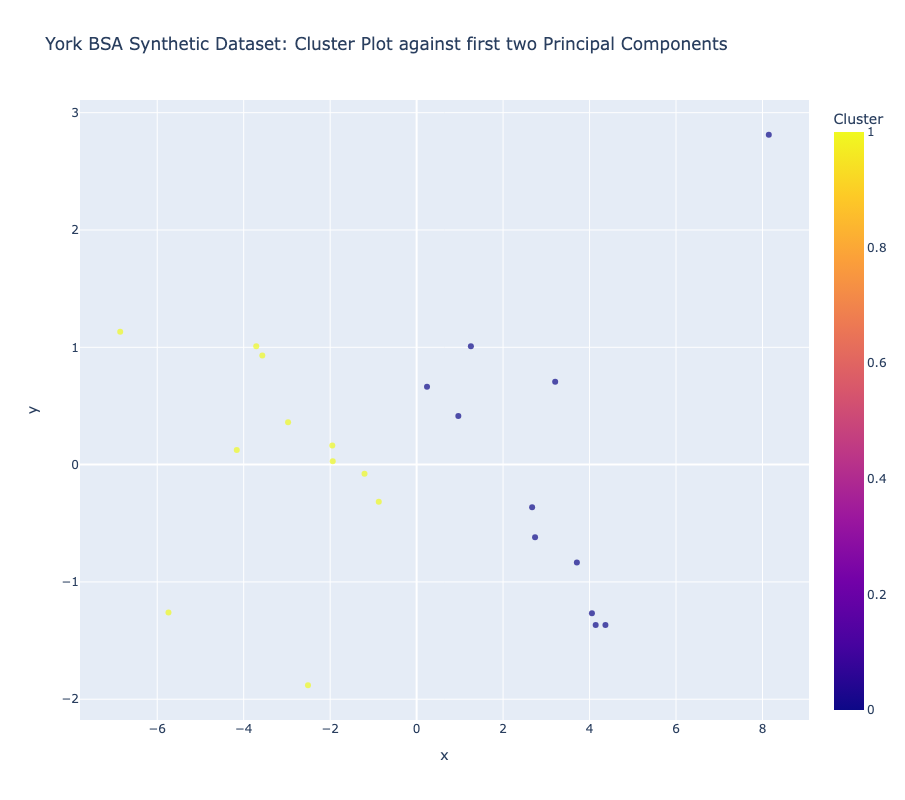

These two components explain 89.33% of the point variability.


<Figure size 600x800 with 0 Axes>

In [69]:
# printing a scatter plot for results
plt.figure(figsize=(6, 8))
fig = px.scatter(x=pca_result2[:, 0], y=pca_result2[:, 1], color=clusters2,
                 labels={'color': 'Cluster'},
                 title='York BSA Synthetic Dataset: Cluster Plot against first two Principal Components',
                 opacity=0.7,
                 width=800, 
                 height=800)

plt.tight_layout()
fig.show()

print(f"These two components explain {(variance_ratio2.sum()*100):.2f}% of the point variability.")

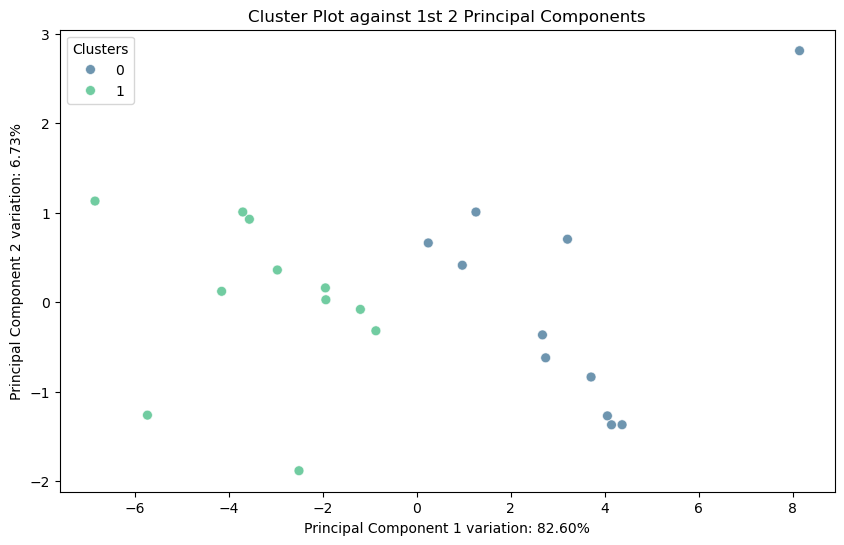

In [65]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_result2[:, 0], y=pca_result2[:, 1], hue=clusters2, palette='viridis', s=50, alpha=0.7)
plt.title('Cluster Plot against 1st 2 Principal Components')
plt.xlabel(f'Principal Component 1 variation: {variance_ratio2[0]*100:.2f}%')
plt.ylabel(f'Principal Component 2 variation: {variance_ratio2[1]*100:.2f}%')
plt.legend(title='Clusters')
plt.savefig("/Users/saffytaylor/Desktop/cluster_ploty.png")
plt.show()

In [54]:
cluster_centers_k2 = pd.DataFrame(kmeans2.cluster_centers_, columns=bsa_z2.columns, )
cluster_centers_k2.to_csv("data/cluster_centers_k2.csv", index=False)
cluster_centers_k2.head()

,polInter_yes,welf_pro,redist_pro,lean_left,lean_right,lean_centr,rel_christ,rel_nonchrist,rel_non,nat_british,nat_english,race_white,race_asian,race_mixed,race_other,disab_aff,Cluster
0,-0.848768,-0.849211,0.321616,0.833096,-0.85437,-0.594021,-0.865306,0.685499,0.867079,0.720282,-0.595691,-0.850576,0.805192,0.770979,0.856632,-0.810998,0.0
1,0.848768,0.849211,-0.321616,-0.833096,0.85437,0.594021,0.865306,-0.685499,-0.867079,-0.720282,0.595691,0.850576,-0.805192,-0.770979,-0.856632,0.810998,1.0


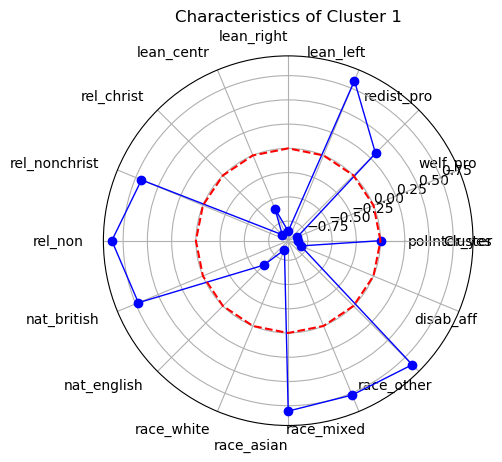

In [62]:
first_row_centers_k2 = cluster_centers_k2.iloc[0, :]

# saving the length of features
num_features_k2 = len(first_row_centers_k2)

# getting the polar coordinates
theta_k2 = np.linspace(0, 2 * np.pi, num_features_k2, endpoint=True)

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
 # plots the centres
ax.plot(theta_k2, first_row_centers_k2, linewidth=1, color='blue', marker='o', label='Centers')

 # adding the red line into the plot where the value is 0.0
ax.plot(theta_k2, np.zeros_like(first_row_centers_k2), color='red', linestyle='--', label='Avarage')

ax.set_xticks(theta_k2)
ax.set_xticklabels(cluster_centers_k2.columns, rotation=45, ha='right')
plt.title("Characteristics of Cluster 1")
plt.savefig("/Users/saffytaylor/Desktop/first_cluster.png") 
plt.show()

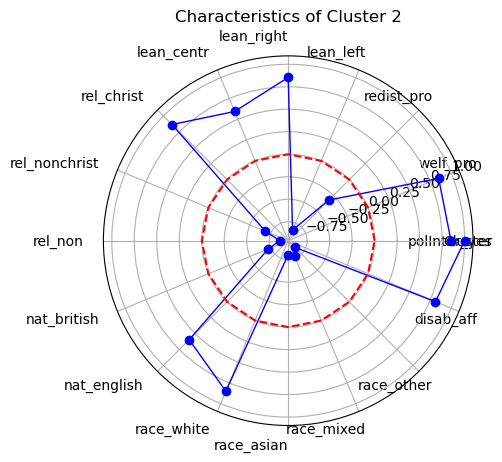

In [63]:
second_row_centers_k2 = cluster_centers_k2.iloc[1, :]

# saving the length of features
num_features_k2 = len(second_row_centers_k2)

# getting the polar coordinates
theta_k2 = np.linspace(0, 2 * np.pi, num_features_k2, endpoint=True)

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
 # plots the centres
ax.plot(theta_k2, second_row_centers_k2, linewidth=1, color='blue', marker='o', label='Centers')

 # adding the red line into the plot where the value is 0.0
ax.plot(theta_k2, np.zeros_like(second_row_centers_k2), color='red', linestyle='--', label='Avarage')

ax.set_xticks(theta_k2)
ax.set_xticklabels(cluster_centers_k2.columns, rotation=45, ha='right')
plt.title("Characteristics of Cluster 2")
plt.savefig("/Users/saffytaylor/Desktop/second_cluster.png")
plt.show()

### Test 2: Four Clusters

In [ ]:
bsa_z4 = bsa_z.copy() # making a deep copy

In [ ]:
kmeans4 = KMeans(n_clusters=4, random_state=0) # defining our cluster number as 4 and defining a seed
kmeans4.fit(bsa_z4)
labels = kmeans4.predict(bsa_z4)
cluster_centres4 = kmeans4.cluster_centers_

bsa_z4['Cluster'] = kmeans4.labels_

In [ ]:
bsa_z4.to_csv("data/bsa_z4k.csv", index=False) # saving this dataset with 4 clusters

In [ ]:
clusters4 = kmeans4.fit_predict(bsa_z4)

bsa_z4['Cluster'] = clusters4

# Standardize the data for PCA
scaler4 = StandardScaler()
stand_data_scaled4 = scaler4.fit_transform(bsa_z4)

pca4 = PCA(n_components=2).fit(stand_data_scaled4)
pca_result4 = pca4.transform(stand_data_scaled4)

# calculating percentage variance
variance_ratio4 = pca4.explained_variance_ratio_

In [ ]:
# printing a scatter plot for results
plt.figure(figsize=(12, 8))
fig = px.scatter(x=pca_result4[:, 0], y=pca_result4[:, 1], color=clusters4,
                 labels={'color': 'Cluster'},
                 title='York BSA Synthetic Dataset: Cluster Plot against first two Principal Components',
                 opacity=0.7,
                 width=800, 
                 height=800)

plt.tight_layout()
fig.show()

print(f"These two components explain {(variance_ratio4.sum()*100):.2f}% of the point variability.")

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_result4[:, 0], y=pca_result4[:, 1], hue=clusters4, palette='viridis', s=50, alpha=0.7)
plt.title('Cluster Plot against 1st 2 Principal Components')
plt.xlabel(f'Principal Component 1 variation: {variance_ratio4[0]*100:.2f}%')
plt.ylabel(f'Principal Component 2 variation: {variance_ratio4[1]*100:.2f}%')
plt.legend(title='Clusters')
plt.show()

In [ ]:
cluster_centers_k4 = pd.DataFrame(kmeans4.cluster_centers_, columns=bsa_z4.columns, )
cluster_centers_k4.to_csv("data/cluster_centers_k4.csv", index=False)
cluster_centers_k4.head()

In [ ]:
# looking at the characteristics of the first cluster
first_row_centers_k4 = cluster_centers_k4.iloc[0, :]

# saving the length of features
num_features_k4 = len(first_row_centers_k4)

# getting the polar coordinates
theta_k4 = np.linspace(0, 2 * np.pi, num_features_k4, endpoint=True)

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
 # plots the centres
ax.plot(theta_k4, first_row_centers_k4, linewidth=1, color='blue', marker='o', label='Centers')

 # adding the red line into the plot where the value is 0.0
ax.plot(theta_k4, np.zeros_like(first_row_centers_k4), color='red', linestyle='--', label='Avarage')

ax.set_xticks(theta_k4)
ax.set_xticklabels(cluster_centers_k4.columns, rotation=45, ha='right')
plt.title("Characteristics of Cluster 1")
plt.show()

In [ ]:
# looking at the characteristics of the second cluster
second_row_centers_k4 = cluster_centers_k4.iloc[1, :]

# saving the length of features
num_features_k4 = len(second_row_centers_k4)

# getting the polar coordinates
theta_k4 = np.linspace(0, 2 * np.pi, num_features_k4, endpoint=True)

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
 # plots the centres
ax.plot(theta_k4, second_row_centers_k4, linewidth=1, color='blue', marker='o', label='Centers')

 # adding the red line into the plot where the value is 0.0
ax.plot(theta_k4, np.zeros_like(second_row_centers_k4), color='red', linestyle='--', label='Avarage')

ax.set_xticks(theta_k4)
ax.set_xticklabels(cluster_centers_k4.columns, rotation=45, ha='right')
plt.title("Characteristics of Cluster 2")
plt.show()

In [ ]:
# looking at the characteristics of the third cluster
third_row_centers_k4 = cluster_centers_k4.iloc[2, :]

# saving the length of features
num_features_k4 = len(third_row_centers_k4)

# getting the polar coordinates
theta_k4 = np.linspace(0, 2 * np.pi, num_features_k4, endpoint=True)

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
 # plots the centres
ax.plot(theta_k4, third_row_centers_k4, linewidth=1, color='blue', marker='o', label='Centers')

 # adding the red line into the plot where the value is 0.0
ax.plot(theta_k4, np.zeros_like(third_row_centers_k4), color='red', linestyle='--', label='Avarage')

ax.set_xticks(theta_k4)
ax.set_xticklabels(cluster_centers_k4.columns, rotation=45, ha='right')
plt.title("Characteristics of Cluster 3")
plt.show()

In [ ]:
# looking at the characteristics of the forth cluster
forth_row_centers_k4 = cluster_centers_k4.iloc[3, :]

# saving the length of features
num_features_k4 = len(forth_row_centers_k4)

# getting the polar coordinates
theta_k4 = np.linspace(0, 2 * np.pi, num_features_k4, endpoint=True)

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(theta_k4, forth_row_centers_k4, linewidth=1, color='blue', marker='o', label='Centers')

 # adding the red line into the plot where the value is 0.0
ax.plot(theta_k4, np.zeros_like(third_row_centers_k4), color='red', linestyle='--', label='Avarage')

ax.set_xticks(theta_k4)
ax.set_xticklabels(cluster_centers_k4.columns, rotation=45, ha='right')
plt.title("Characteristics of Cluster 4")
plt.show()

### Test 3: Five Clusters

Carrying this out after testing clustering without age and sex included.

In [ ]:
bsa_z5 = bsa_z.copy() # making a deep copy
kmeans5 = KMeans(n_clusters=5, random_state=0) # defining our cluster number as 5 and defining a seed
kmeans5.fit(bsa_z5)
labels = kmeans5.predict(bsa_z5)
cluster_centres5 = kmeans5.cluster_centers_

bsa_z5['Cluster'] = kmeans5.labels_
bsa_z5.to_csv("data/bsa_z5k.csv", index=False) # saving this dataset with 5 clusters

In [ ]:
clusters5 = kmeans5.fit_predict(bsa_z5)

bsa_z5['Cluster'] = clusters5

# Standardize the data for PCA
scaler5 = StandardScaler()
stand_data_scaled5 = scaler5.fit_transform(bsa_z5)

pca5 = PCA(n_components=2).fit(stand_data_scaled5)
pca_result5 = pca5.transform(stand_data_scaled5)

# calculating percentage variance
variance_ratio5 = pca5.explained_variance_ratio_

In [ ]:
# printing a scatter plot for results
plt.figure(figsize=(12, 8))
fig = px.scatter(x=pca_result5[:, 0], y=pca_result5[:, 1], color=clusters5,
                 labels={'color': 'Cluster'},
                 title='York BSA Synthetic Dataset: Cluster Plot against first two Principal Components',
                 opacity=0.7,
                 width=800, 
                 height=800)

plt.tight_layout()
fig.show()

print(f"These two components explain {(variance_ratio5.sum()*100):.2f}% of the point variability.")

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_result5[:, 0], y=pca_result5[:, 1], hue=clusters5, palette='viridis', s=50, alpha=0.7)
plt.title('Cluster Plot against 1st 2 Principal Components')
plt.xlabel(f'Principal Component 1 variation: {variance_ratio5[0]*100:.2f}%')
plt.ylabel(f'Principal Component 2 variation: {variance_ratio5[1]*100:.2f}%')
plt.legend(title='Clusters')
plt.show()

In [ ]:
cluster_centers_k5 = pd.DataFrame(kmeans5.cluster_centers_, columns=bsa_z5.columns, )
cluster_centers_k5.to_csv("data/cluster_centers_k5.csv", index=False)
cluster_centers_k5.head()

In [ ]:
# looking at the characteristics of the first cluster
first_row_centers_k5 = cluster_centers_k5.iloc[0, :]

# saving the length of features
num_features_k5 = len(first_row_centers_k5)

# getting the polar coordinates
theta_k5 = np.linspace(0, 2 * np.pi, num_features_k5, endpoint=True)

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
 # plots the centres
ax.plot(theta_k5, first_row_centers_k5, linewidth=1, color='blue', marker='o', label='Centers')

 # adding the red line into the plot where the value is 0.0
ax.plot(theta_k5, np.zeros_like(first_row_centers_k5), color='red', linestyle='--', label='Avarage')

ax.set_xticks(theta_k5)
ax.set_xticklabels(cluster_centers_k5.columns, rotation=45, ha='right')
plt.title("Characteristics of Cluster 1")
plt.show()

In [ ]:
# looking at the characteristics of the second cluster
second_row_centers_k5 = cluster_centers_k5.iloc[1, :]

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(theta_k5, second_row_centers_k5, linewidth=1, color='blue', marker='o', label='Centers')
ax.plot(theta_k5, np.zeros_like(second_row_centers_k5), color='red', linestyle='--', label='Avarage')

ax.set_xticks(theta_k5)
ax.set_xticklabels(cluster_centers_k5.columns, rotation=45, ha='right')
plt.title("Characteristics of Cluster 2")
plt.show()

In [ ]:
# looking at the characteristics of the third cluster
third_row_centers_k5 = cluster_centers_k5.iloc[2, :]

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(theta_k5, third_row_centers_k5, linewidth=1, color='blue', marker='o', label='Centers')
ax.plot(theta_k5, np.zeros_like(third_row_centers_k5), color='red', linestyle='--', label='Avarage')

ax.set_xticks(theta_k5)
ax.set_xticklabels(cluster_centers_k5.columns, rotation=45, ha='right')
plt.title("Characteristics of Cluster 3")
plt.show()

In [ ]:
# looking at the characteristics of the forth cluster
forth_row_centers_k5 = cluster_centers_k5.iloc[3, :]

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(theta_k5, forth_row_centers_k5, linewidth=1, color='blue', marker='o', label='Centers')
ax.plot(theta_k5, np.zeros_like(forth_row_centers_k5), color='red', linestyle='--', label='Avarage')

ax.set_xticks(theta_k5)
ax.set_xticklabels(cluster_centers_k5.columns, rotation=45, ha='right')
plt.title("Characteristics of Cluster 4")
plt.show()

In [ ]:
# looking at the characteristics of the fifth cluster
fifth_row_centers_k5 = cluster_centers_k5.iloc[4, :]

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(theta_k5, fifth_row_centers_k5, linewidth=1, color='blue', marker='o', label='Centers')
ax.plot(theta_k5, np.zeros_like(fifth_row_centers_k5), color='red', linestyle='--', label='Avarage')

ax.set_xticks(theta_k5)
ax.set_xticklabels(cluster_centers_k5.columns, rotation=45, ha='right')
plt.title("Characteristics of Cluster 5")
plt.show()

## Step 8: Mapping the clusters

From our testing we've settled on two clusters, which clusters areas 'right-leaning' and 'left-leaning'. The final step to our geodemographic is then mapping these clusters. Therefore we'll reimport the z-score dataframe we created based upon segmenting our zones into two clusters. We'll remove all of the z-score columns we've created, and add back all of the aggregate data we started with.

In [70]:
bsa_zscores = bsa_z2.copy()

In [71]:
bsa_zscores.columns

Index(['polInter_yes', 'welf_pro', 'redist_pro', 'lean_left', 'lean_right',
       'lean_centr', 'rel_christ', 'rel_nonchrist', 'rel_non', 'nat_british',
       'nat_english', 'race_white', 'race_asian', 'race_mixed', 'race_other',
       'disab_aff', 'Cluster'],
      dtype='object')

In [72]:
bsa_zscores.drop([
    'polInter_yes',
    'welf_pro',
    'redist_pro', 
    'lean_left', 'lean_right', 'lean_centr',
    'rel_christ', 'rel_nonchrist', 'rel_non', 
    'nat_british', 'nat_english',
    'race_white', 'race_asian', 'race_mixed', 'race_other',
    'disab_aff'], axis=1, inplace=True)
bsa_zscores['Cluster'] = bsa_zscores['Cluster'].astype(str)
bsa_zscores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Cluster  22 non-null     object
dtypes: object(1)
memory usage: 308.0+ bytes


In [73]:
final_BSA = pd.concat([BSA_geom, bsa_zscores], axis=1, ignore_index=False)
final_BSA.head()

,geo_code,total_pop,age1864,age65,female,male,support_yes,support_no,support_DNR,support_conservative,...,voted_labour,voted_libdem,voted_green,voted_UKIP,voted_other,voted_no_reponse,ons_label,geo_label,geometry,Cluster
0,E05001745,6736,5191,1545,3508,3228,3400,3312,24,2051,...,2609,734,338,111,129,454,00FFNG,Acomb,"POLYGON ((456577.594 451960.781, 456577.934 45...",1
1,E05001746,3179,2175,1004,1680,1499,1622,1547,10,1006,...,1192,363,154,48,59,215,00FFNH,Bishopthorpe,"POLYGON ((459746.803 446400.173, 459746.777 44...",1
2,E05001747,11113,9413,1700,5821,5292,5538,5530,45,3266,...,4423,1163,572,192,228,729,00FFNJ,Clifton,"POLYGON ((460891.532 453105.406, 460891.778 45...",0
3,E05001748,2914,1875,1039,1535,1379,1502,1402,10,954,...,1072,333,132,45,52,207,00FFNK,Derwent,"POLYGON ((466449.953 448892.953, 466428.813 44...",1
4,E05001749,8973,6666,2307,4712,4261,4533,4408,32,2766,...,3454,988,433,146,171,606,00FFNL,Dringhouses and Woodthorpe,"POLYGON ((458809.029 450627.601, 458823.125 45...",1


In [74]:
def rename_column(x):
    x = x.replace('0', 'Left-leaning')
    x = x.replace('1', 'Right-leaning or Centrist')
    return x

final_BSA['Cluster'] = final_BSA['Cluster'].apply(rename_column)

In [75]:
final_BSA.head()

,geo_code,total_pop,age1864,age65,female,male,support_yes,support_no,support_DNR,support_conservative,...,voted_labour,voted_libdem,voted_green,voted_UKIP,voted_other,voted_no_reponse,ons_label,geo_label,geometry,Cluster
0,E05001745,6736,5191,1545,3508,3228,3400,3312,24,2051,...,2609,734,338,111,129,454,00FFNG,Acomb,"POLYGON ((456577.594 451960.781, 456577.934 45...",Right-leaning or Centrist
1,E05001746,3179,2175,1004,1680,1499,1622,1547,10,1006,...,1192,363,154,48,59,215,00FFNH,Bishopthorpe,"POLYGON ((459746.803 446400.173, 459746.777 44...",Right-leaning or Centrist
2,E05001747,11113,9413,1700,5821,5292,5538,5530,45,3266,...,4423,1163,572,192,228,729,00FFNJ,Clifton,"POLYGON ((460891.532 453105.406, 460891.778 45...",Left-leaning
3,E05001748,2914,1875,1039,1535,1379,1502,1402,10,954,...,1072,333,132,45,52,207,00FFNK,Derwent,"POLYGON ((466449.953 448892.953, 466428.813 44...",Right-leaning or Centrist
4,E05001749,8973,6666,2307,4712,4261,4533,4408,32,2766,...,3454,988,433,146,171,606,00FFNL,Dringhouses and Woodthorpe,"POLYGON ((458809.029 450627.601, 458823.125 45...",Right-leaning or Centrist


In [78]:
final_BSA.explore(column='Cluster', cmap='bwr', tiles='OpenStreetMap')

## Graphs for use in Report

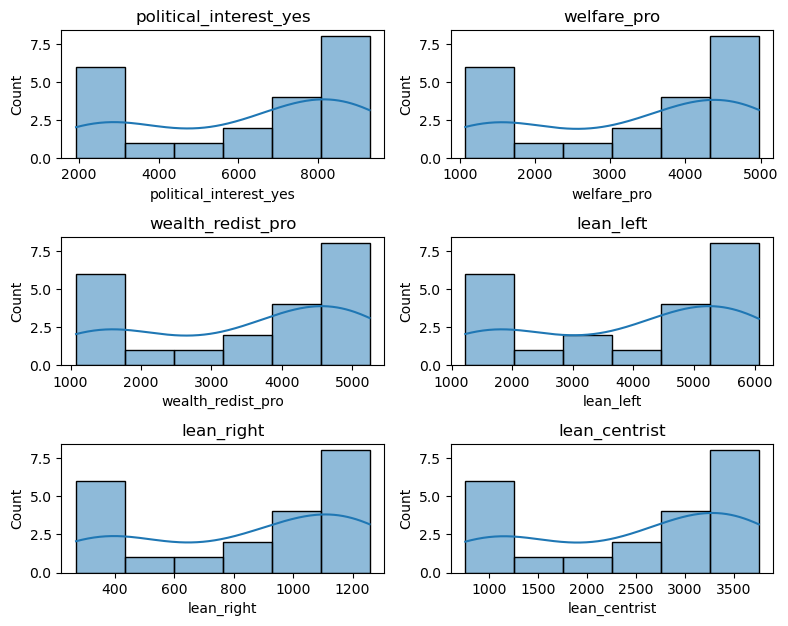

In [33]:
attributes_to_plot = ['political_interest_yes',
                      'welfare_pro',
                      'wealth_redist_pro',
                      'lean_left',
                      'lean_right',
                      'lean_centrist'

                     ]

plt.figure(figsize=(8, 8))

for i, attribute in enumerate(attributes_to_plot,1):
    plt.subplot(4, 2, i)
    sns.histplot(BSA_geom[attribute], kde=True)
    plt.title(attribute)

plt.tight_layout()
plt.savefig("/Users/saffytaylor/Desktop/histograms2.png") # saving the output as it's too large to screenshot
plt.show()


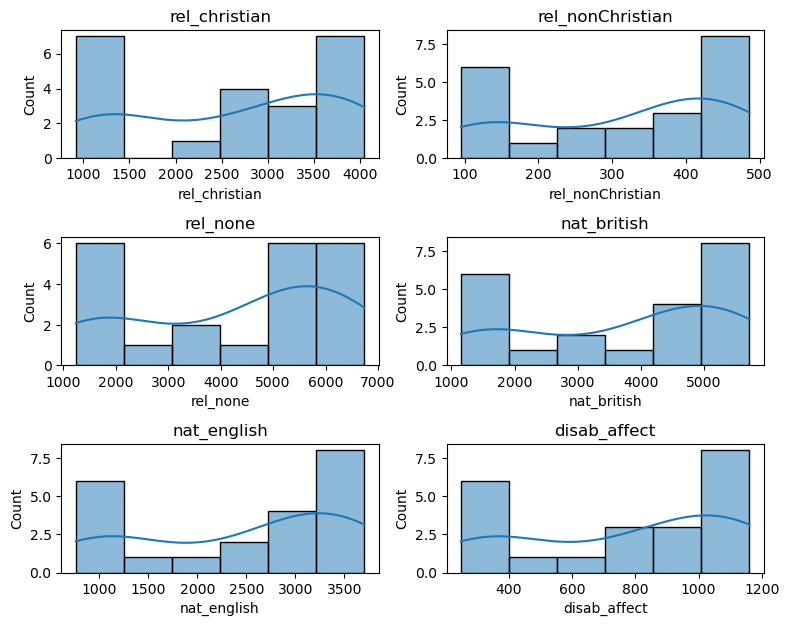

In [38]:
attributes_to_plot = ['rel_christian',
                      'rel_nonChristian',
                      'rel_none',
                      'nat_british',
                      'nat_english',
                      'disab_affect'

                     ]

plt.figure(figsize=(8, 8))

for i, attribute in enumerate(attributes_to_plot,1):
    plt.subplot(4, 2, i)
    sns.histplot(BSA_geom[attribute], kde=True)
    plt.title(attribute)

plt.tight_layout()
plt.savefig("/Users/saffytaylor/Desktop/histograms3.png") # saving the output as it's too large to screenshot
plt.show()


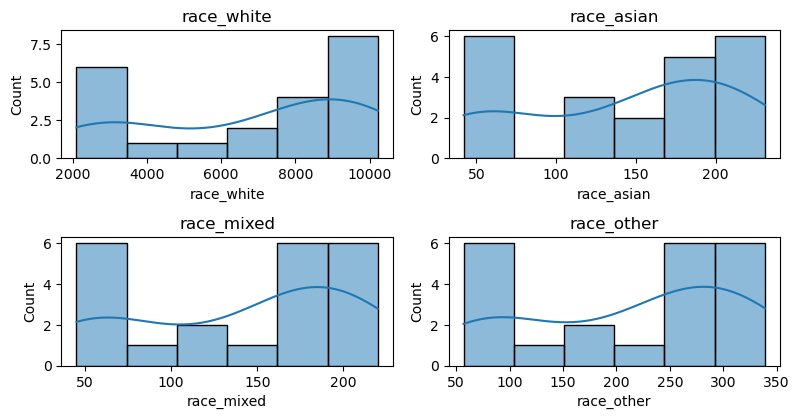

In [31]:
attributes_to_plot = ['race_white',
                      'race_asian',
                      'race_mixed',
                      'race_other'

                     ]

plt.figure(figsize=(8, 8))

for i, attribute in enumerate(attributes_to_plot,1):
    plt.subplot(4, 2, i)
    sns.histplot(BSA_geom[attribute], kde=True)
    plt.title(attribute)

plt.tight_layout()
plt.savefig("/Users/saffytaylor/Desktop/histograms4.png") # saving the output as it's too large to screenshot
plt.show()
